# **PRÁCTICA 5:  Machine Learning - Parte 2: Árboles de decisión para la regresión**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 3ª curso del Grado Ciencia de Datos

## Árboles para regresión

La base del funcionamiento de los árboles para regresión es la misma que para clasificación: buscamos las variables más descriptivas para particionar el espacio de entrada para modelizar la función de salida.

Las diferencias con los árboles para clasificación son:

- En cada nodo (grupo) en lugar de predecir según la clase más numerosa se predice tomando la media de las muestras que lo componen.

- La medida para subdividir cada nodo es el RMSE, MAE o similares.

Para ilustrar su funcionamiento usaremos el RMSE:
$$ \textrm{RMSE} = \sqrt{\frac{1}{N}\sum(y_i-\overline{y})^2} $$

donde $\overline{y}$ es la media de las muestras en un nodo. Esto es lo mismo que decir que se va a utilizar la desviación estándar de las muestras en cada nodo.

Para ilustrar el problema de regresión utilizaremos una onda sinc.

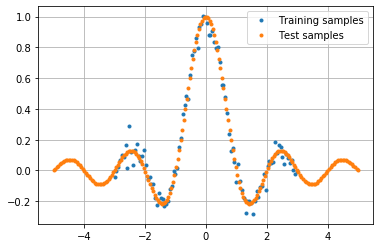

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xtrain = np.linspace(-3, 3, 100)
ytrain = np.sinc(xtrain) + \
    0.05 * np.random.randn(xtrain.shape[0])
xtest = np.linspace(-5, 5, 200)
ytest = np.sinc(xtest)

plt.plot(xtrain, ytrain, '.', label='Training samples')
plt.plot(xtest, ytest, '.', label='Test samples')
plt.legend(), plt.grid(1);

Definimos nuestra función para medir el error.

In [ ]:
def rmse(y):
    """
    RMSE of vector y against its mean
    (the standard deviation)
    """
    # Hay que multiplicar por el número de muestras
    # (¿se te ocurre la razón?)
    return np.std(y) * len(y)

Como en en el ejemplo de clasificación haremos una prueba haciendo una única partición para entender cómo funciona el algoritmo.

In [ ]:
threshold = None
rmse_root = rmse(ytrain)
rmse_min = rmse_root  # float('inf')
for th in xtrain:
    idx = xtrain <= th
    y_left = ytrain[idx]
    y_right = ytrain[~idx]

    # Calculamos RMSE respecto a la media de los puntos
    rmse_left = rmse(y_left)
    rmse_right = rmse(y_right)

    if (rmse_left + rmse_right) < rmse_min:
        # Mejoramos RMSE
        rmse_min = rmse_left + rmse_right
        threshold = th

if threshold is not None:
    print('Minimizamos RMSE al pariticionar en %6.4f' % threshold)
    idx = xtrain <= threshold
    y_left = ytrain[idx]
    y_right = ytrain[~idx]

    rmse_left = rmse(y_left)
    rmse_right = rmse(y_right)

    print('RMSE left  %5.3f' % rmse_left,
          'RMSE right %5.3f' % rmse_right,
          'RMSE root  %5.3f' % rmse_root)
    
    print('Predict left  %6.4f' % np.mean(y_left),
          'Predict right %6.4f' % np.mean(y_right))
else:
    print('No minimizamos RMSE')

Minimizamos RMSE al pariticionar en 0.7576
RMSE left  24.629 RMSE right 4.819 RMSE root  35.428
Predict left  0.2899 Predict right -0.0239


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Vamos a automatizar el proceso. El código que vamos usar es prácticamente el mismo que el usado para clasificación. Unicamente cambiará la manera de predecir y la métrica que usamos para ir dividiendo los nodos.

Primero creamos nuestra clase `Node`:

In [ ]:
class Node:
    def __init__(self, y, error):
        """
        error: rmse, std o similar
        """
        # Predecimos la media
        self.predicted_value = np.mean(y)
        self.error = error
        self.feature = None
        self.threshold = None
        self.left = None
        self.right = None

    # Estas clases nos sirven para obtener información
    # de un nodo al hacer 'print'
    def __repr__(self):
        self.show()
        return '\r'

    def show(self, depth=0):
        print('  ' * depth, 'error', self.error)
        print('  ' * depth, 'mean', self.predicted_value)
        print('  ' * depth, 'feature', self.feature)
        print('  ' * depth, 'threshold', self.threshold)

Ahora creamos la clase `Tree`:

In [ ]:
class Tree:
    def __init__(self, y, maxdepth=10):
        self.node = Node(y, rmse(y))
        self.maxdepth = maxdepth

    def __repr__(self):
        self.show()
        return '\r'

    def show(self, depth=0, node=None):
        if node is None:
            node = self.node
        node.show(depth)
        if node.left is not None:
            print('  ' * depth, 'left')
            self.show(depth+1, node.left)
        if node.right is not None:
            print('  ' * depth, 'right')
            self.show(depth+1, node.right)


    def find_split(self, X, y, node_error):
        min_error = node_error
        if min_error == 0:
            return None, None, None, None
        
        el, er = min_error, min_error
        feature, threshold = None, None
        for feat in range(X.shape[1]):
            for th in X[:,feat]:
                idx = X[:,feat] <= th
                error_l = rmse(y[idx])
                error_r = rmse(y[~idx])
                if (error_l + error_r) < min_error:
                    min_error = error_l + error_r
                    el = error_l
                    er = error_r
                    feature = feat
                    threshold = th

        return feature, threshold, el, er

    
    def fit(self, X, y, depth=0, node=None):
        if depth >= self.maxdepth:
            return None

        if node is None:
            node = self.node

        feature, threshold, el, er = self.find_split(X, y, node.error)
        if threshold is not None:
            node.feature = feature
            node.threshold = threshold

            idx = X[:, feature] <= threshold

            X_left, y_left = X[idx, :], y[idx]
            node.left = Node(y_left, el)
            self.fit(X_left, y_left, depth+1, node.left)

            X_right, y_right = X[~idx, :], y[~idx]
            node.right = Node(y_right, er)
            self.fit(X_right, y_right, depth+1, node.right)

    
    def predict_one(self, xtest):
        node = self.node
        while node.threshold is not None:
            # print('th', node.threshold)
            if xtest[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        
        # print('ent', node.entropy)
        return node.predicted_value

    def predict(self, Xtest):
        return np.array(
            [self.predict_one(xtest) for xtest in Xtest]
        )

## Ejercicio:

- Compara esta clase `Tree` con la que teníamos para clasificación e indica donde están las diferencias. 

- Opcional: crea una clase base `Tree` y luego deriva de ella las subclases `TreeClassification` y `TreeRegression` implementando solamente los métodos que cambian.


### Probemos el árbol en regresión

In [ ]:
# Nuestro algoritmo necesita que las X sean 2D
xtrain, xtest = xtrain.reshape(-1,1), xtest.reshape(-1,1)
# Creamos el árbol y lo entrenamos
tree = Tree(ytrain, maxdepth=10)
tree.fit(xtrain, ytrain)

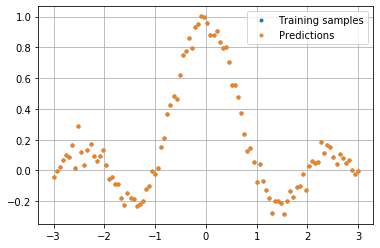

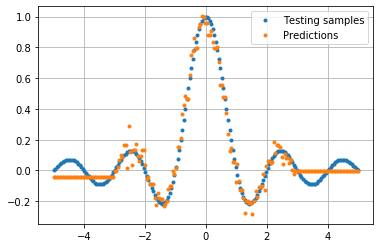

In [ ]:
# A ver qué tal funciona
yp = tree.predict(xtrain)

plt.plot(xtrain, ytrain, '.', label='Training samples')
plt.plot(xtrain, yp, '.', label='Predictions')
plt.grid(1), plt.legend()

yt = tree.predict(xtest)
plt.figure()
plt.plot(xtest, ytest, '.', label='Testing samples')
plt.plot(xtest, yt, '.', label='Predictions')
plt.grid(1), plt.legend();

## Ejercicio:
Modifica el código para usar como medida para particionar el MAE (*mean absolute error*) y compara los resultados.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

xtrain = np.linspace(-3, 3, 100)
ytrain = np.sinc(xtrain) + \
    0.05 * np.random.randn(xtrain.shape[0])
xtest = np.linspace(-5, 5, 200)
ytest = np.sinc(xtest)

In [ ]:
# Utilizamos la medida para particionar de MAE
def mae(y):
    return np.sum(abs(np.mean(y)-y))/y.shape[0]*len(y)

In [ ]:
# Modificamos código anterior 
threshold = None
mae_root = mae(ytrain)
mae_min = mae_root  # float('inf')
for th in xtrain:
    idx = xtrain <= th
    y_left = ytrain[idx]
    y_right = ytrain[~idx]

    # Calculamos RMSE respecto a la media de los puntos
    mae_left = mae(y_left)
    mae_right = mae(y_right)

    if (mae_left + mae_right) < mae_min:
        # Mejoramos MAE
        mae_min = mae_left + mae_right
        threshold = th

if threshold is not None:
    print('Minimizamos MAE al pariticionar en %6.4f' % threshold)
    idx = xtrain <= threshold
    y_left = ytrain[idx]
    y_right = ytrain[~idx]

    mae_left = mae(y_left)
    mae_right = mae(y_right)

    print('MAE left  %5.3f' % mae_left,
          'MAE right %5.3f' % mae_right,
          'MAE root  %5.3f' % mae_root)
    
    print('Predict left  %6.4f' % np.mean(y_left),
          'Predict right %6.4f' % np.mean(y_right))
else:
    print('No minimizamos MAE')

Minimizamos MAE al pariticionar en 0.8788
MAE left  22.314 MAE right 4.005 MAE root  28.526
Predict left  0.2880 Predict right -0.0375


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


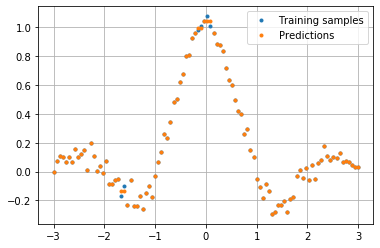

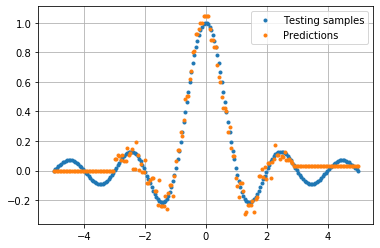

In [ ]:
# Nuestro algoritmo necesita que las X sean 2D
xtrain, xtest = xtrain.reshape(-1,1), xtest.reshape(-1,1)
# Creamos el árbol y lo entrenamos
tree = Tree(ytrain, maxdepth=10)
tree.fit(xtrain, ytrain)

# A ver qué tal funciona
yp = tree.predict(xtrain)

plt.plot(xtrain, ytrain, '.', label='Training samples')
plt.plot(xtrain, yp, '.', label='Predictions')
plt.grid(1), plt.legend()

yt = tree.predict(xtest)
plt.figure()
plt.plot(xtest, ytest, '.', label='Testing samples')
plt.plot(xtest, yt, '.', label='Predictions')
plt.grid(1), plt.legend();

### Aquí podemos comparar los resultados con ambas medidas

![Captura%20de%20pantalla%202020-12-08%20a%20las%2012.39.17.png](attachment:Captura%20de%20pantalla%202020-12-08%20a%20las%2012.39.17.png)

![Captura%20de%20pantalla%202020-12-08%20a%20las%2012.39.28.png](attachment:Captura%20de%20pantalla%202020-12-08%20a%20las%2012.39.28.png)

## Árboles de regresión con scikit-learn
En scikit-learn tenemos `DecisionTreeRegressor`.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
clf = dtr.fit(xtrain, ytrain)
dtr.score(xtest, ytest)

0.9640294352503769

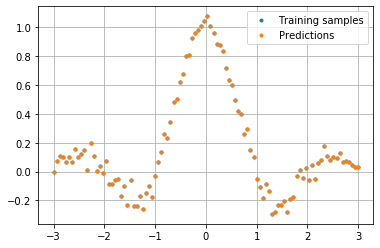

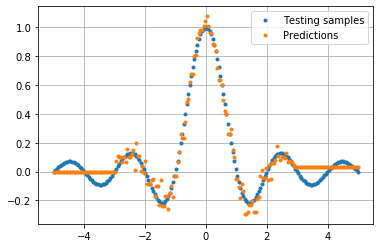

In [ ]:
# Gráficamente ...
yp = dtr.predict(xtrain)

plt.plot(xtrain, ytrain, '.', label='Training samples')
plt.plot(xtrain, yp, '.', label='Predictions')
plt.grid(1), plt.legend()

yt = dtr.predict(xtest)
plt.figure()
plt.plot(xtest, ytest, '.', label='Testing samples')
plt.plot(xtest, yt, '.', label='Predictions')
plt.grid(1), plt.legend();

## Ejercicio:
Representa el árbol mediante `plot_tree`.

- A la vista del resultado, ¿crees que se puede obtener alguna información útil en este caso?

<Figure size 432x288 with 0 Axes>

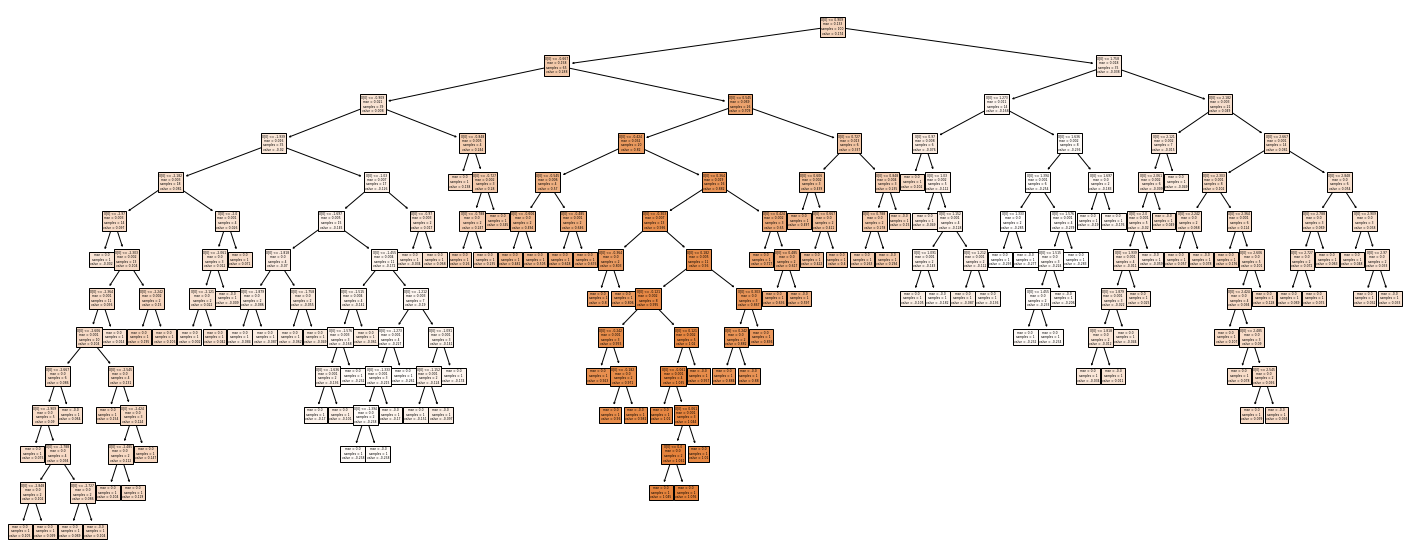

In [ ]:
from sklearn.tree import plot_tree
plt.figure()
plt.figure(figsize = (25,10))
plot_tree(clf, filled=True)
plt.show()

# Como el árbol es tan grande no podemos ver ninugna información útil en este caso, por eso vamos a variar el 
# parámetro max_depth = 4 a ver que pasa.

- Reentrena el árbol usando un valor menor del parámetro `maxdepth`. Muestra los resultados en predicción y el árbol resultante.

<Figure size 432x288 with 0 Axes>

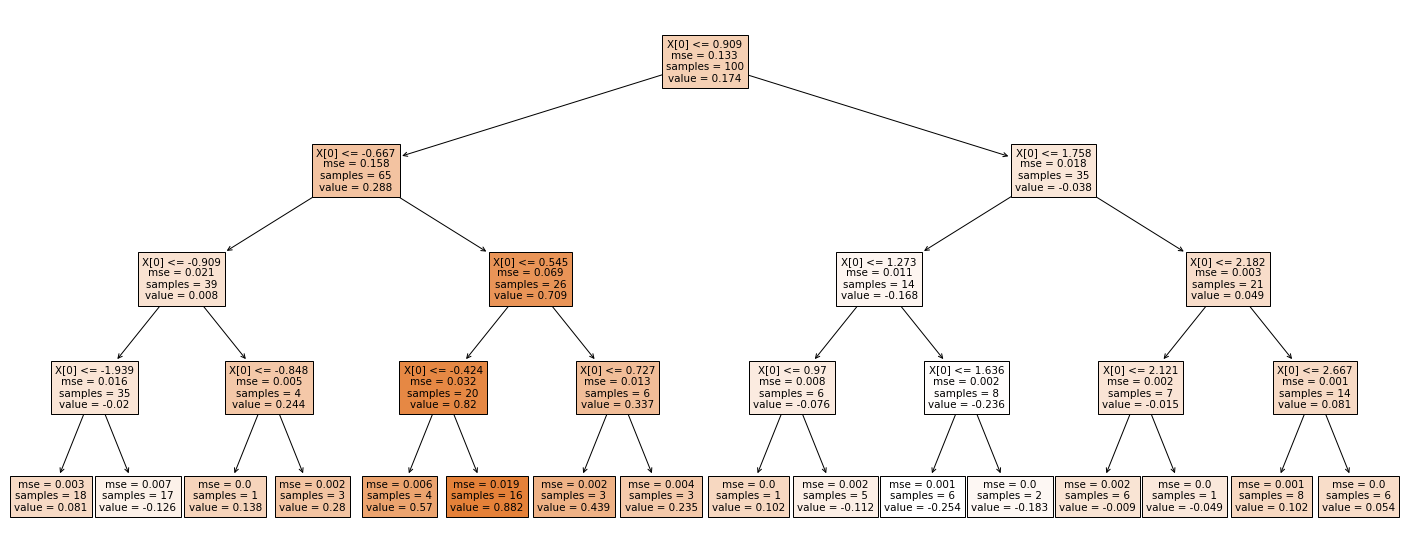

In [ ]:
from sklearn.tree import plot_tree
plt.figure()
dtr = DecisionTreeRegressor( max_depth = 4)
clf = dtr.fit(xtrain, ytrain)
dtr.score(xtrain, ytrain)

plt.figure(figsize = (25,10))
plot_tree(clf , filled=True)
plt.show()

Podemos ver en que puntos se han definido umbrales y qué valores han tomado las medias en los nodos.

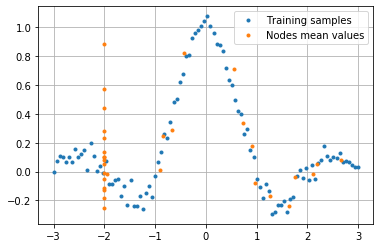

In [ ]:
ths = dtr.tree_.threshold
vls = dtr.tree_.value
plt.plot(xtrain, ytrain, '.', label='Training samples')
plt.plot(ths, vls.squeeze(), '.', label='Nodes mean values')
plt.grid(1), plt.legend();
# plt.plot(ths, dtr.tree_.n_node_samples, '.')
# plt.plot(ths, dtr.tree_.weighted_n_node_samples, '.')

## Ejercicio 3
Utiliza `DecisionTreeRegression` con el dataset `load_diabetes`.
- Entrena un modelo y muestra el árbol gráficamente.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes

data, target = load_diabetes(return_X_y = True)
dtr = DecisionTreeRegressor()

# Generamos dataset de entrenamiento y test de nuevo.
X_train, X_test, y_train, y_test = train_test_split(data, target ,test_size=0.3)
fit = dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(309, 10) (133, 10) (309,) (133,)


<Figure size 432x288 with 0 Axes>

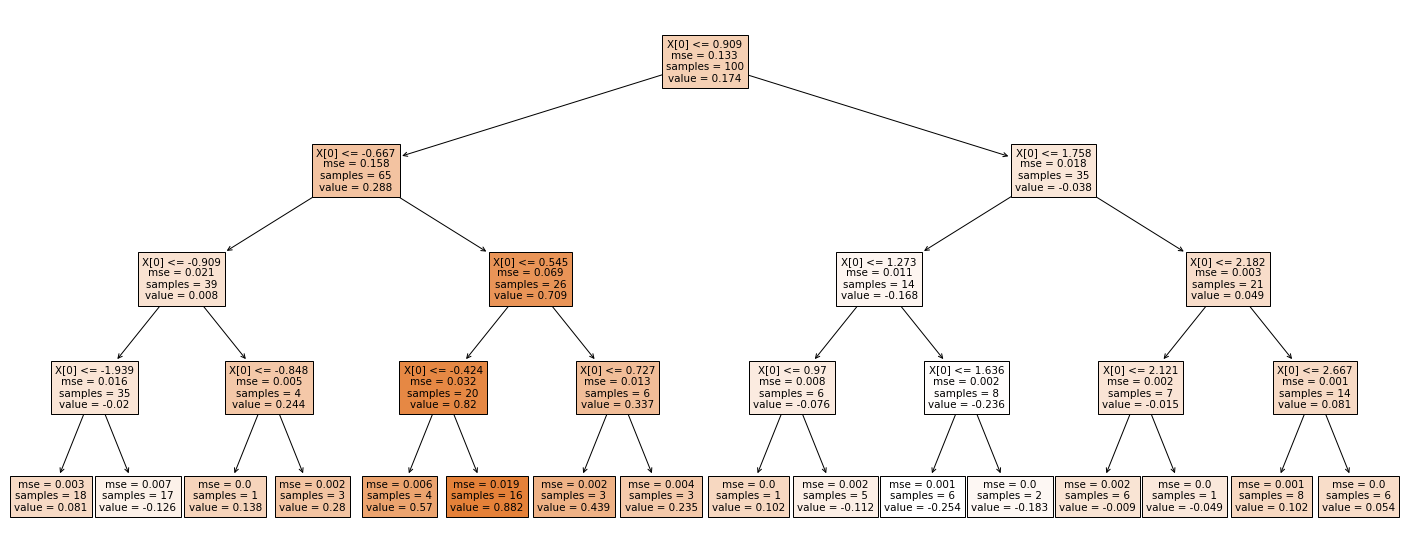

In [ ]:
plt.figure()
plt.figure(figsize = (25,10))
plot_tree(clf, filled=True)
plt.show()

- Muestra en qué puntos se ha muestreado y qué valores medios tienen los nodos.

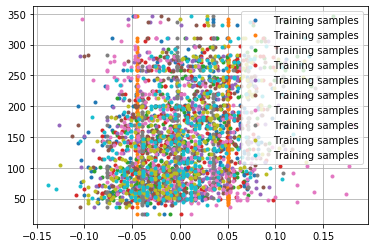

In [ ]:
ths = dtr.tree_.threshold
vls = dtr.tree_.value
plt.plot(X_train, y_train, '.', label = 'Training samples')
plt.plot(ths, vls.squeeze, '.', label = 'Nodes mean values')
plt.grid(1)
plt.legend()

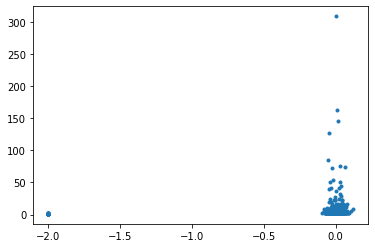

In [ ]:
plt.plot(ths, dtr.tree_.n_node_samples, '.')

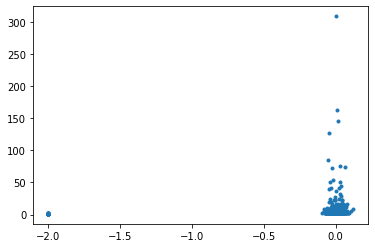

In [ ]:
plt.plot(ths, dtr.tree_.weighted_n_node_samples, '.')